In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [70]:
def fetch_spy_data(start_date, end_date, interval='1d'):
    """
    Fetch SPY data using yfinance API
    """
    spy = yf.Ticker("SPY")
    df = spy.history(start=start_date, end=end_date, interval=interval)
    df = df.reset_index()
    return df

In [71]:
def calculate_atr(data, period=14):
    """
    Calculate the Average True Range (ATR) and add it to the DataFrame.
    """
    data = data.copy()
    data['High-Low'] = data['High'] - data['Low']
    data['High-Close'] = np.abs(data['High'] - data['Close'].shift())
    data['Low-Close'] = np.abs(data['Low'] - data['Close'].shift())

    data['True Range'] = data[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    data['ATR'] = data['True Range'].rolling(window=period).mean()

    # Drop intermediate columns to keep the DataFrame clean
    data.drop(['High-Low', 'High-Close', 'Low-Close', 'True Range'], axis=1, inplace=True)
    return data

In [72]:
def generate_grid_levels(price, grid_spacing_pct, num_levels=10):
   """
   Generate grid levels above and below current price
   """
   grid_spacing = price * (grid_spacing_pct / 100)
   levels_above = np.array([price + (i * grid_spacing) for i in range(num_levels)])
   levels_below = np.array([price - (i * grid_spacing) for i in range(num_levels)])
   return np.sort(np.concatenate([levels_below, levels_above]))

In [75]:
def generate_grid_signals(data, grid_spacing_pct=0.2):
    """
    Generate trading signals based on grid levels and price movements
    """
    data = data.copy()
    data['Signal'] = 0  # Default no signal
    data['Grid_Level'] = 0.0  # Track active grid level

    for i in range(1, len(data)):
        current_price = data['Close'].iloc[i]
        prev_price = data['Close'].iloc[i-1]
        
        # Generate grid levels around previous price
        grid_levels = generate_grid_levels(prev_price, grid_spacing_pct)
        
        # Find nearest grid levels
        nearest_level_above = grid_levels[grid_levels > prev_price].min()
        nearest_level_below = grid_levels[grid_levels < prev_price].max()
        
        # Signal generation logic
        if prev_price < current_price:  # Price moving up
            if current_price > nearest_level_above:
                data.loc[data.index[i], 'Signal'] = -1  # Sell signal
                data.loc[data.index[i], 'Grid_Level'] = nearest_level_above
        else:  # Price moving down
            if current_price < nearest_level_below:
                data.loc[data.index[i], 'Signal'] = 1  # Buy signal
                data.loc[data.index[i], 'Grid_Level'] = nearest_level_below

    return data

In [63]:
def calculate_position_size(portfolio_value, risk_per_trade, atr):
    """
    Calculate position size based on portfolio risk and ATR.
    """
    risk_dollars = portfolio_value * risk_per_trade
    position_size = risk_dollars / atr  # Volatility-adjusted size
    return int(position_size)  # Ensure it's a whole number of shares


In [64]:
def calculate_exit_levels(entry_price, atr, stop_loss_multiplier=2, take_profit_multiplier=2):
    stop_loss = entry_price - stop_loss_multiplier * atr
    take_profit = entry_price + take_profit_multiplier * atr
    return stop_loss, take_profit

In [76]:
 def backtest_grid_strategy(data, initial_capital=100000, transaction_cost=0.001):
    """
    Backtest the grid trading strategy
    """
    portfolio = pd.DataFrame(index=data.index)
    portfolio['Price'] = data['Close']
    portfolio['Signal'] = data['Signal']
    portfolio['Grid_Level'] = data['Grid_Level']
    
    # Initialize portfolio metrics
    portfolio['Position'] = 0
    portfolio['Cash'] = initial_capital
    portfolio['Holdings'] = 0
    portfolio['Portfolio_Value'] = initial_capital
    
    position = 0
    cash = initial_capital
    
    for i in range(1, len(portfolio)):
        price = portfolio['Price'].iloc[i]
        signal = portfolio['Signal'].iloc[i]
        
        # Execute trades based on signals
        if signal == 1:  # Buy signal
            shares_to_buy = cash * 0.1 // price  # Use 10% of available cash
            if shares_to_buy > 0:
                cost = shares_to_buy * price * (1 + transaction_cost)
                if cost <= cash:
                    position += shares_to_buy
                    cash -= cost
                    
        elif signal == -1:  # Sell signal
            if position > 0:
                shares_to_sell = position * 0.1  # Sell 10% of position
                revenue = shares_to_sell * price * (1 - transaction_cost)
                position -= shares_to_sell
                cash += revenue
        
        # Update portfolio metrics
        portfolio.loc[portfolio.index[i], 'Position'] = position
        portfolio.loc[portfolio.index[i], 'Cash'] = cash
        portfolio.loc[portfolio.index[i], 'Holdings'] = position * price
        portfolio.loc[portfolio.index[i], 'Portfolio_Value'] = cash + (position * price)
    
    return portfolio

In [54]:
# Calculate Sharpe ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    sharpe_ratio = excess_returns.mean() / excess_returns.std()
    return sharpe_ratio


In [66]:
def calculate_max_drawdown(portfolio_values):
    """
    Calculate maximum drawdown
    """
    peak = portfolio_values.cummax()
    drawdown = (portfolio_values - peak) / peak
    return drawdown.min()

In [77]:
def plot_results(data, portfolio):
    """
    Plot trading results
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Plot 1: Price and Signals
    ax1.plot(data.index, data['Close'], label='SPY Price', alpha=0.5)
    
    # Plot buy signals
    buys = data[data['Signal'] == 1]
    ax1.scatter(buys.index, buys['Close'], 
               color='green', marker='^', s=100, label='Buy Signal')
    
    # Plot sell signals
    sells = data[data['Signal'] == -1]
    ax1.scatter(sells.index, sells['Close'], 
               color='red', marker='v', s=100, label='Sell Signal')
    
    ax1.set_title('SPY Price and Grid Trading Signals')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Portfolio Value
    ax2.plot(portfolio.index, portfolio['Portfolio_Value'], 
             label='Portfolio Value', color='blue')
    ax2.set_title('Portfolio Value Over Time')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Value ($)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2836/474924995.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '90092.73513983155' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio.loc[portfolio.index[i], 'Cash'] = cash
/tmp/ipykernel_2836/474924995.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9897.367492675781' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio.loc[portfolio.index[i], 'Holdings'] = position * price
/tmp/ipykernel_2836/474924995.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99990.10263250733' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio.loc[portfolio.index[i], 'Portfolio_Value'] = cash + (p

Total Return: 26.04%
Total Trades: 825
Final Portfolio Value: $126,035.92


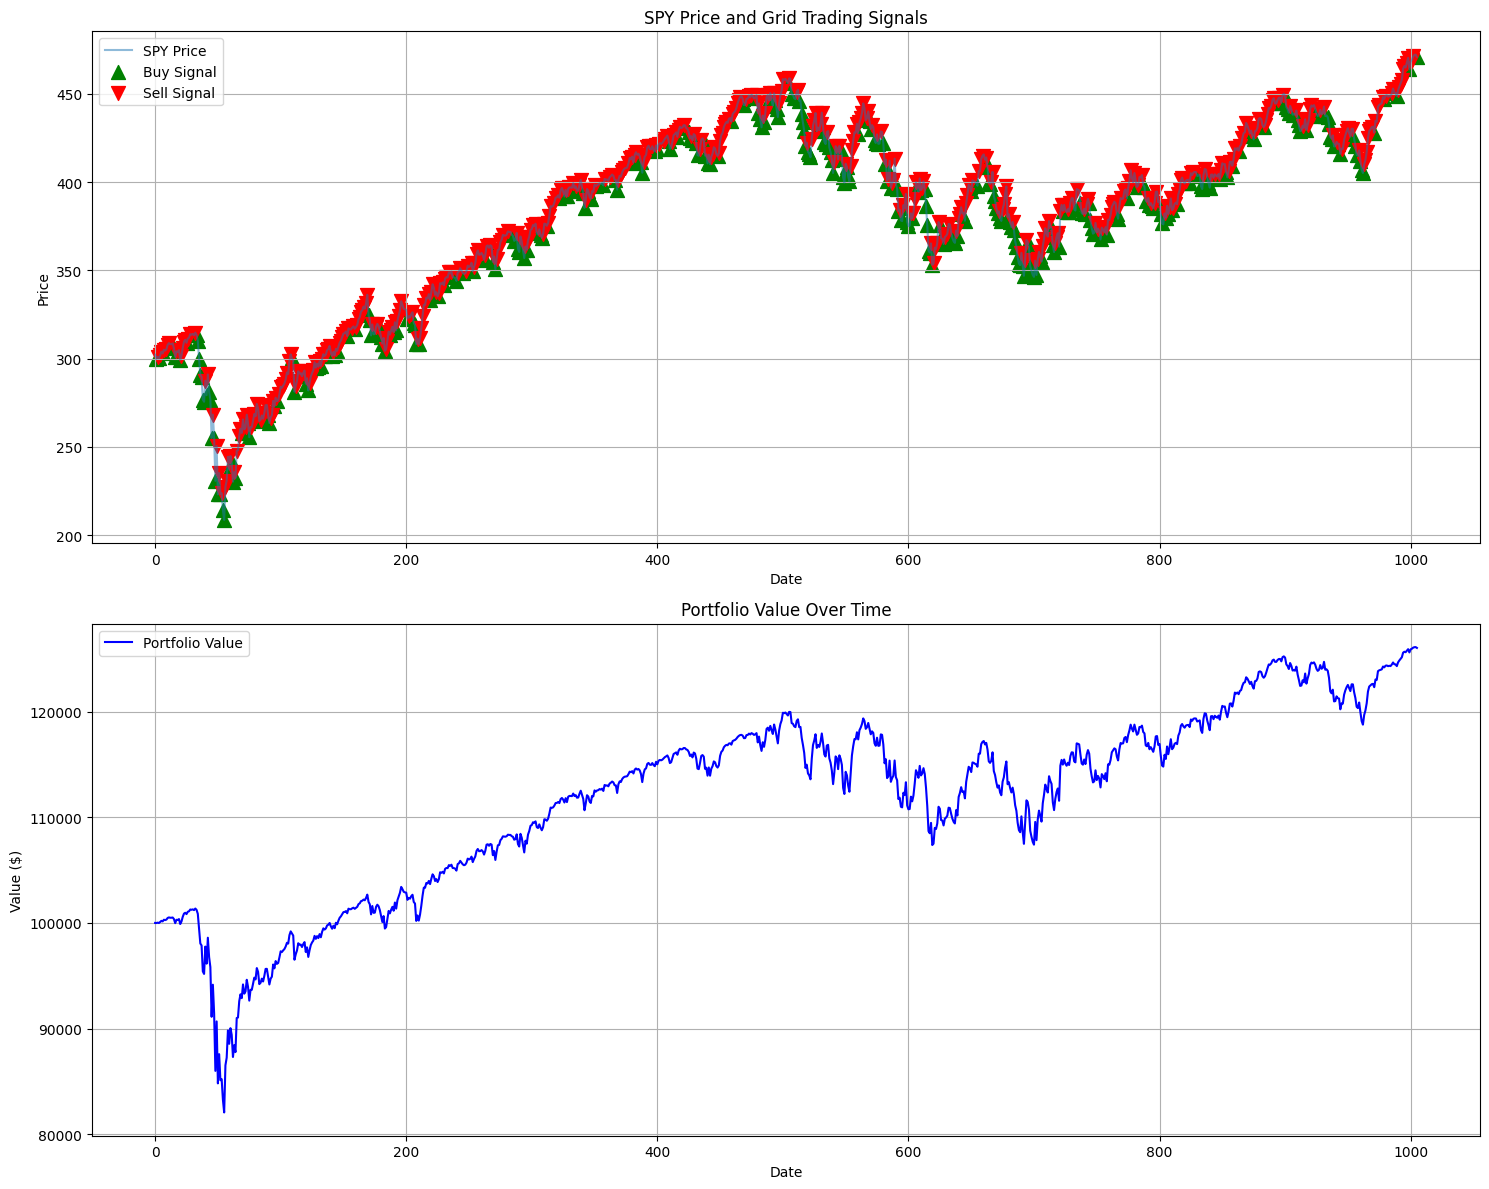

In [78]:
start_date = '2020-01-01'
end_date = '2023-12-31'
grid_spacing_pct = 0.2
initial_capital = 100000

# Fetch data
data = fetch_spy_data(start_date, end_date)

# Generate signals
data = generate_grid_signals(data, grid_spacing_pct)

# Run backtest
portfolio = backtest_grid_strategy(data, initial_capital)

# Calculate and display metrics
total_return = (portfolio['Portfolio_Value'].iloc[-1] - initial_capital) / initial_capital * 100
total_trades = len(data[data['Signal'] != 0])

print(f"Total Return: {total_return:.2f}%")
print(f"Total Trades: {total_trades}")
print(f"Final Portfolio Value: ${portfolio['Portfolio_Value'].iloc[-1]:,.2f}")

# Plot results
plot_results(data, portfolio)